# In this notebook we will train the random forest model

Rows in file: 45875

Label mapping:
  class 0: < -0.50% → -1.00%
  class 1: -1.00% → +1.00%
  class 2: +1.00% → ≥ +0.50%

Train rows: 37,096 | Test rows: 8,755
Class dist (train): [ 5033 26500  5563]
Class dist (test) : [1038 6660 1057]

Classification report:
                   precision    recall  f1-score   support

< -0.50% → -1.00%       0.25      0.00      0.00      1038
  -1.00% → +1.00%       0.76      1.00      0.86      6660
+1.00% → ≥ +0.50%       0.57      0.01      0.01      1057

         accuracy                           0.76      8755
        macro avg       0.53      0.34      0.29      8755
     weighted avg       0.68      0.76      0.66      8755



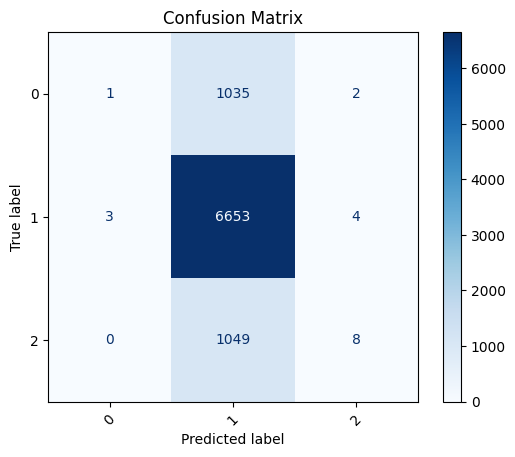

Overall OVR ROC-AUC: 0.605

Top feature importances:
      Feature  Importance
       atr_14       0.085
   band_width       0.080
    roc_7days       0.078
   Volume BTC       0.075
      roc_24h       0.070
vol_ratio_24h       0.061
 lower_shadow       0.059
 upper_shadow       0.059
         body       0.059
       roc_4h       0.057
 ret_over_atr       0.056
       boll_b       0.055
         high       0.052
        close       0.052
          low       0.052


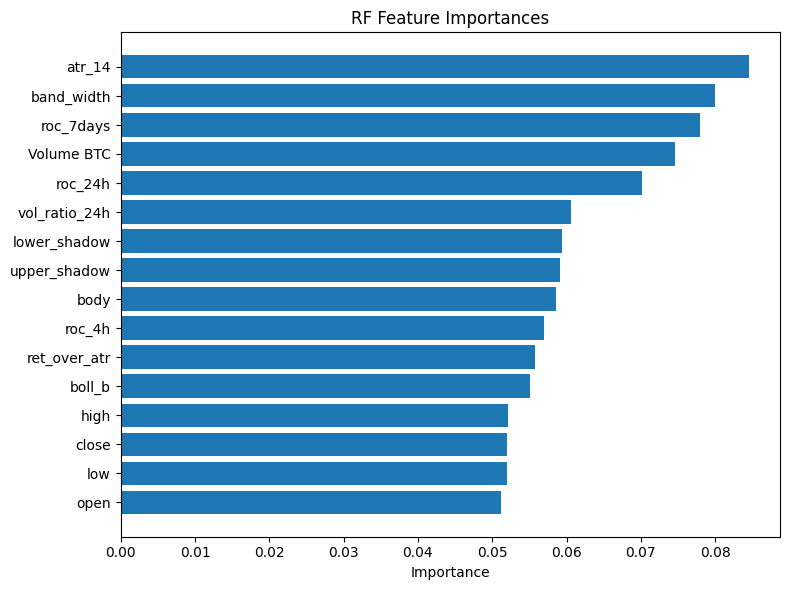

In [35]:
# ──────────────────────────  CONFIG  ────────────────────────────
CSV_PATH       = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2020.csv"
HORIZON_HOURS  = 4                       # 1, 4, 24 …
BUCKETS        = [-0.01, 0.01]         # –0.50 % and +0.50 % cut-points
TEST_YEARS     = 1                       # hold-out period

# ─────────────────────────── IMPORTS ────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve)

# ─────────────────────────── LOAD DATA ──────────────────────────
df = (pd.read_csv(Path(CSV_PATH))
        .assign(date=lambda d: pd.to_datetime(d["date"]))        # ISO strings
        .sort_values("date")
        .reset_index(drop=True))
print("Rows in file:", len(df))

# ───────────────────  BUILD LABELS (pd.cut, leak-free) ──────────
bins   = [-np.inf] + sorted(BUCKETS) + [np.inf]                  # 3 buckets
df["y"] = pd.cut(
            (df["close"].shift(-HORIZON_HOURS) - df["close"]) / df["close"],
            bins=bins, labels=False, right=False)

# ───────────────────  ADD VOLATILITY FEATURES  ──────────────────
# True Range
df["tr"] = np.maximum.reduce([
    df["high"] - df["low"],
    (df["high"] - df["close"].shift()).abs(),
    (df["low"]  - df["close"].shift()).abs()
])

# ATR-14 (exponential)
df["atr_14"] = df["tr"].ewm(span=14, adjust=False).mean()

# Bollinger band-width (20-period, shifted 1 → no leakage)
mid = df["close"].rolling(20, min_periods=20).mean().shift(1)
std = df["close"].rolling(20, min_periods=20).std().shift(1)
df["band_width"] = ((mid + 2*std) - (mid - 2*std)) / mid

# Normalised return
df["ret_over_atr"] = df["roc_4h"] / df["atr_14"]

# ───────────────────  FEATURE LIST  ─────────────────────────────
BASE_FEATURES = [
    "open", "high", "low", "close", "Volume BTC",
    "roc_4h", "roc_24h", "roc_7days",
    "body", "upper_shadow", "lower_shadow",
    "boll_b", "vol_ratio_24h",
]
NEW_VOL_FEATS = ["atr_14", "band_width", "ret_over_atr"]  # ← added
FEATURE_COLS  = BASE_FEATURES + NEW_VOL_FEATS

# Drop rows with any NaNs in predictors or label
df = df.dropna(subset=FEATURE_COLS + ["y"]).reset_index(drop=True)

# ───────────────────  HUMAN-READABLE CLASS NAMES  ───────────────
def edge_str(x):
    return f"{x*100:+.2f}%" if np.isfinite(x) else ("< -0.50%" if x == -np.inf else "≥ +0.50%")
target_names = [f"{edge_str(bins[i])} → {edge_str(bins[i+1])}"
                for i in range(len(bins)-1)]
print("\nLabel mapping:")
for i, t in enumerate(target_names): print(f"  class {i}: {t}")

# ───────────────────  TIME-BASED SPLIT  ─────────────────────────
cutoff = df["date"].max() - pd.DateOffset(years=TEST_YEARS)
train_mask = df["date"] < cutoff

X_train = df.loc[train_mask, FEATURE_COLS].values
y_train = df.loc[train_mask, "y"].astype(int).values
X_test  = df.loc[~train_mask, FEATURE_COLS].values
y_test  = df.loc[~train_mask, "y"].astype(int).values

print(f"\nTrain rows: {len(y_train):,} | Test rows: {len(y_test):,}")
print("Class dist (train):", np.bincount(y_train, minlength=len(bins)-1))
print("Class dist (test) :", np.bincount(y_test , minlength=len(bins)-1))

# ───────────────────  RANDOM FOREST  ────────────────────────────
rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
     ).fit(X_train, y_train)

# ───────────────────  METRICS  ──────────────────────────────────
print("\nClassification report:")
print(classification_report(
        y_test, rf.predict(X_test),
        labels=np.arange(len(target_names)),
        target_names=target_names,
        zero_division=0))

ConfusionMatrixDisplay.from_estimator(
        rf, X_test, y_test, labels=np.arange(len(target_names)),
        cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix"); plt.show()

if len(rf.classes_) == len(target_names):
    proba = rf.predict_proba(X_test)
    auc   = roc_auc_score(y_test, proba, multi_class="ovr")
    print(f"Overall OVR ROC-AUC: {auc:.3f}")
else:
    print("ROC-AUC skipped (model saw no samples in at least one class).")

# ───────────────────  FEATURE IMPORTANCE  ───────────────────────
importances = rf.feature_importances_
feat_imp_df = (pd.DataFrame({"Feature": FEATURE_COLS, "Importance": importances})
                 .sort_values("Importance", ascending=False))
print("\nTop feature importances:")
print(feat_imp_df.head(15).to_string(index=False))

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("RF Feature Importances"); plt.xlabel("Importance")
plt.tight_layout(); plt.show()


Rows in file: 63356

Label mapping:
  class 0: < -0.50% → -1.00%
  class 1: -1.00% → +1.00%
  class 2: +1.00% → ≥ +0.50%

Train rows: 54,577 | Test rows: 8,755
Class dist (train): [ 7666 38748  8163]
Class dist (test) : [1038 6660 1057]

Classification report:
                   precision    recall  f1-score   support

< -0.50% → -1.00%       0.17      0.00      0.00      1038
  -1.00% → +1.00%       0.76      1.00      0.86      6660
+1.00% → ≥ +0.50%       0.68      0.01      0.02      1057

         accuracy                           0.76      8755
        macro avg       0.54      0.34      0.30      8755
     weighted avg       0.68      0.76      0.66      8755



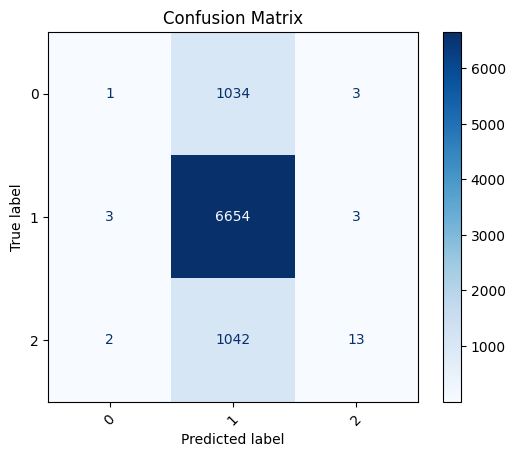

Overall OVR ROC-AUC: 0.607

Top feature importances:
      Feature  Importance
   band_width       0.086
       atr_14       0.081
    roc_7days       0.081
   Volume BTC       0.074
      roc_24h       0.071
vol_ratio_24h       0.062
         body       0.058
 lower_shadow       0.058
 upper_shadow       0.058
       roc_4h       0.058
       boll_b       0.056
 ret_over_atr       0.056
         high       0.050
        close       0.050
          low       0.050


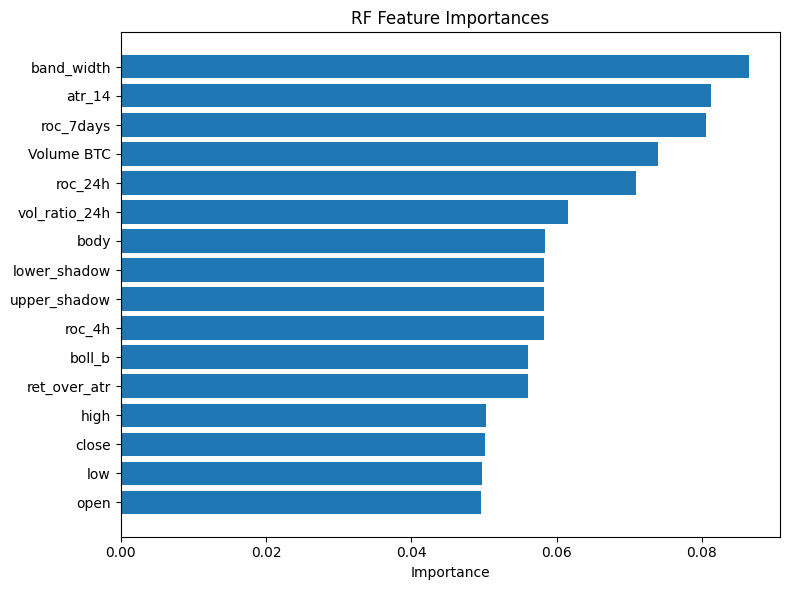

In [32]:
# ──────────────────────────  CONFIG  ────────────────────────────
CSV_PATH       = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2018.csv"
HORIZON_HOURS  = 4                 # 1, 4, 24 …
BUCKETS        = [-0.01, 0.01]         # –0.50 % and +0.50 % cut-points
TEST_YEARS     = 1                       # hold-out period

# ─────────────────────────── IMPORTS ────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve)

# ─────────────────────────── LOAD DATA ──────────────────────────
df = (pd.read_csv(Path(CSV_PATH))
        .assign(date=lambda d: pd.to_datetime(d["date"]))        # ISO strings
        .sort_values("date")
        .reset_index(drop=True))
print("Rows in file:", len(df))

# ───────────────────  BUILD LABELS (pd.cut, leak-free) ──────────
bins   = [-np.inf] + sorted(BUCKETS) + [np.inf]                  # 3 buckets
df["y"] = pd.cut(
            (df["close"].shift(-HORIZON_HOURS) - df["close"]) / df["close"],
            bins=bins, labels=False, right=False)

# ───────────────────  ADD VOLATILITY FEATURES  ──────────────────
# True Range
df["tr"] = np.maximum.reduce([
    df["high"] - df["low"],
    (df["high"] - df["close"].shift()).abs(),
    (df["low"]  - df["close"].shift()).abs()
])

# ATR-14 (exponential)
df["atr_14"] = df["tr"].ewm(span=14, adjust=False).mean()

# Bollinger band-width (20-period, shifted 1 → no leakage)
mid = df["close"].rolling(20, min_periods=20).mean().shift(1)
std = df["close"].rolling(20, min_periods=20).std().shift(1)
df["band_width"] = ((mid + 2*std) - (mid - 2*std)) / mid

# Normalised return
df["ret_over_atr"] = df["roc_4h"] / df["atr_14"]

# ───────────────────  FEATURE LIST  ─────────────────────────────
BASE_FEATURES = [
    "open", "high", "low", "close", "Volume BTC",
    "roc_4h", "roc_24h", "roc_7days",
    "body", "upper_shadow", "lower_shadow",
    "boll_b", "vol_ratio_24h",
]
NEW_VOL_FEATS = ["atr_14", "band_width", "ret_over_atr"]  # ← added
FEATURE_COLS  = BASE_FEATURES + NEW_VOL_FEATS

# Drop rows with any NaNs in predictors or label
df = df.dropna(subset=FEATURE_COLS + ["y"]).reset_index(drop=True)

# ───────────────────  HUMAN-READABLE CLASS NAMES  ───────────────
def edge_str(x):
    return f"{x*100:+.2f}%" if np.isfinite(x) else ("< -0.50%" if x == -np.inf else "≥ +0.50%")
target_names = [f"{edge_str(bins[i])} → {edge_str(bins[i+1])}"
                for i in range(len(bins)-1)]
print("\nLabel mapping:")
for i, t in enumerate(target_names): print(f"  class {i}: {t}")

# ───────────────────  TIME-BASED SPLIT  ─────────────────────────
cutoff = df["date"].max() - pd.DateOffset(years=TEST_YEARS)
train_mask = df["date"] < cutoff

X_train = df.loc[train_mask, FEATURE_COLS].values
y_train = df.loc[train_mask, "y"].astype(int).values
X_test  = df.loc[~train_mask, FEATURE_COLS].values
y_test  = df.loc[~train_mask, "y"].astype(int).values

print(f"\nTrain rows: {len(y_train):,} | Test rows: {len(y_test):,}")
print("Class dist (train):", np.bincount(y_train, minlength=len(bins)-1))
print("Class dist (test) :", np.bincount(y_test , minlength=len(bins)-1))

# ───────────────────  RANDOM FOREST  ────────────────────────────
rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
     ).fit(X_train, y_train)

# ───────────────────  METRICS  ──────────────────────────────────
print("\nClassification report:")
print(classification_report(
        y_test, rf.predict(X_test),
        labels=np.arange(len(target_names)),
        target_names=target_names,
        zero_division=0))

ConfusionMatrixDisplay.from_estimator(
        rf, X_test, y_test, labels=np.arange(len(target_names)),
        cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix"); plt.show()

if len(rf.classes_) == len(target_names):
    proba = rf.predict_proba(X_test)
    auc   = roc_auc_score(y_test, proba, multi_class="ovr")
    print(f"Overall OVR ROC-AUC: {auc:.3f}")
else:
    print("ROC-AUC skipped (model saw no samples in at least one class).")

# ───────────────────  FEATURE IMPORTANCE  ───────────────────────
importances = rf.feature_importances_
feat_imp_df = (pd.DataFrame({"Feature": FEATURE_COLS, "Importance": importances})
                 .sort_values("Importance", ascending=False))
print("\nTop feature importances:")
print(feat_imp_df.head(15).to_string(index=False))

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("RF Feature Importances"); plt.xlabel("Importance")
plt.tight_layout(); plt.show()


Rows in file: 45875

Label mapping:
  class 0: < -0.50% → -1.00%
  class 1: -1.00% → +1.00%
  class 2: +1.00% → ≥ +0.50%

Train rows: 37,096 | Test rows: 8,755
Class dist (train): [ 5033 26500  5563]
Class dist (test) : [1038 6660 1057]

Classification report:
                   precision    recall  f1-score   support

< -0.50% → -1.00%       0.25      0.00      0.00      1038
  -1.00% → +1.00%       0.76      1.00      0.86      6660
+1.00% → ≥ +0.50%       0.57      0.01      0.01      1057

         accuracy                           0.76      8755
        macro avg       0.53      0.34      0.29      8755
     weighted avg       0.68      0.76      0.66      8755



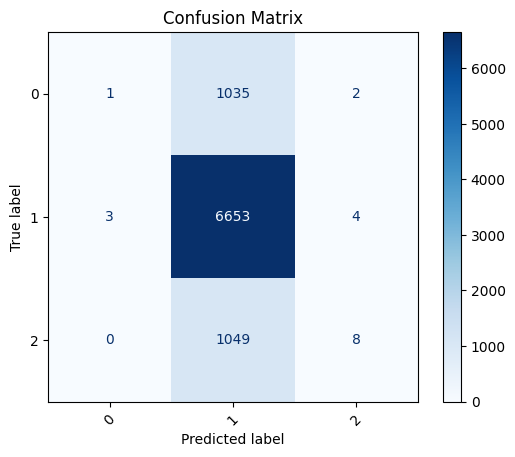

Overall OVR ROC-AUC: 0.605

Top feature importances:
      Feature  Importance
       atr_14    0.084503
   band_width    0.080035
    roc_7days    0.077949
   Volume BTC    0.074559
      roc_24h    0.070205
vol_ratio_24h    0.060581
 lower_shadow    0.059345
 upper_shadow    0.059089
         body    0.058584
       roc_4h    0.056983
 ret_over_atr    0.055730
       boll_b    0.055044
         high    0.052155
        close    0.052046
          low    0.051972


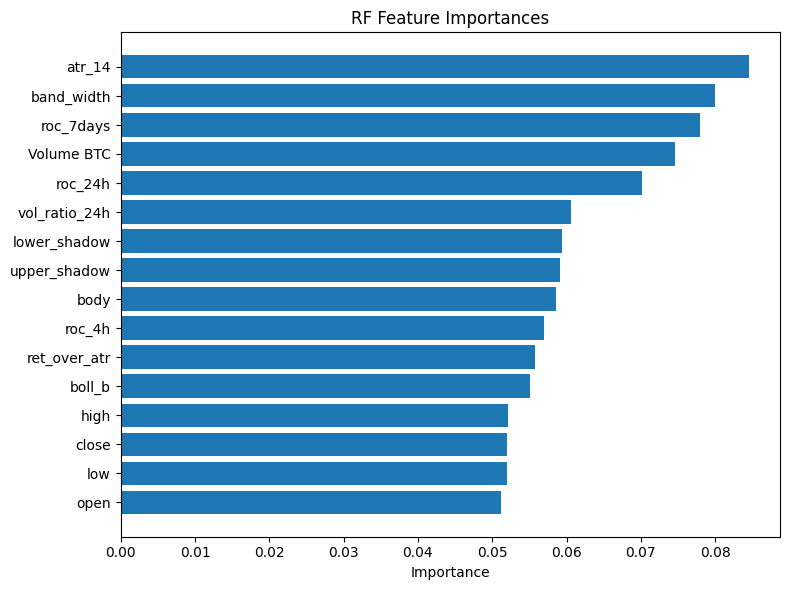

In [1]:
# ──────────────────────────  CONFIG  ────────────────────────────
CSV_PATH       = r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2020.csv"
HORIZON_HOURS  = 4                       # 1, 4, 24 …
BUCKETS        = [-0.01, 0.01]         # –0.50 % and +0.50 % cut-points
TEST_YEARS     = 1                       # hold-out period

# ─────────────────────────── IMPORTS ────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve)

# ─────────────────────────── LOAD DATA ──────────────────────────
df = (pd.read_csv(Path(CSV_PATH))
        .assign(date=lambda d: pd.to_datetime(d["date"]))        # ISO strings
        .sort_values("date")
        .reset_index(drop=True))
print("Rows in file:", len(df))

# ───────────────────  BUILD LABELS (pd.cut, leak-free) ──────────
bins   = [-np.inf] + sorted(BUCKETS) + [np.inf]                  # 3 buckets
df["y"] = pd.cut(
            (df["close"].shift(-HORIZON_HOURS) - df["close"]) / df["close"],
            bins=bins, labels=False, right=False)

# ───────────────────  ADD VOLATILITY FEATURES  ──────────────────
# True Range
df["tr"] = np.maximum.reduce([
    df["high"] - df["low"],
    (df["high"] - df["close"].shift()).abs(),
    (df["low"]  - df["close"].shift()).abs()
])

# ATR-14 (exponential)
df["atr_14"] = df["tr"].ewm(span=14, adjust=False).mean()

# Bollinger band-width (20-period, shifted 1 → no leakage)
mid = df["close"].rolling(20, min_periods=20).mean().shift(1)
std = df["close"].rolling(20, min_periods=20).std().shift(1)
df["band_width"] = ((mid + 2*std) - (mid - 2*std)) / mid

# Normalised return
df["ret_over_atr"] = df["roc_4h"] / df["atr_14"]

# ───────────────────  FEATURE LIST  ─────────────────────────────
BASE_FEATURES = [
    "open", "high", "low", "close", "Volume BTC",
    "roc_4h", "roc_24h", "roc_7days",
    "body", "upper_shadow", "lower_shadow",
    "boll_b", "vol_ratio_24h",
]
NEW_VOL_FEATS = ["atr_14", "band_width", "ret_over_atr"]  # ← added
FEATURE_COLS  = BASE_FEATURES + NEW_VOL_FEATS

# Drop rows with any NaNs in predictors or label
df = df.dropna(subset=FEATURE_COLS + ["y"]).reset_index(drop=True)

# ───────────────────  HUMAN-READABLE CLASS NAMES  ───────────────
def edge_str(x):
    return f"{x*100:+.2f}%" if np.isfinite(x) else ("< -0.50%" if x == -np.inf else "≥ +0.50%")
target_names = [f"{edge_str(bins[i])} → {edge_str(bins[i+1])}"
                for i in range(len(bins)-1)]
print("\nLabel mapping:")
for i, t in enumerate(target_names): print(f"  class {i}: {t}")

# ───────────────────  TIME-BASED SPLIT  ─────────────────────────
cutoff = df["date"].max() - pd.DateOffset(years=TEST_YEARS)
train_mask = df["date"] < cutoff

X_train = df.loc[train_mask, FEATURE_COLS].values
y_train = df.loc[train_mask, "y"].astype(int).values
X_test  = df.loc[~train_mask, FEATURE_COLS].values
y_test  = df.loc[~train_mask, "y"].astype(int).values

print(f"\nTrain rows: {len(y_train):,} | Test rows: {len(y_test):,}")
print("Class dist (train):", np.bincount(y_train, minlength=len(bins)-1))
print("Class dist (test) :", np.bincount(y_test , minlength=len(bins)-1))

# ───────────────────  RANDOM FOREST  ────────────────────────────
rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
     ).fit(X_train, y_train)

# ───────────────────  METRICS  ──────────────────────────────────
print("\nClassification report:")
print(classification_report(
        y_test, rf.predict(X_test),
        labels=np.arange(len(target_names)),
        target_names=target_names,
        zero_division=0))

ConfusionMatrixDisplay.from_estimator(
        rf, X_test, y_test, labels=np.arange(len(target_names)),
        cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix"); plt.show()

if len(rf.classes_) == len(target_names):
    proba = rf.predict_proba(X_test)
    auc   = roc_auc_score(y_test, proba, multi_class="ovr")
    print(f"Overall OVR ROC-AUC: {auc:.3f}")
else:
    print("ROC-AUC skipped (model saw no samples in at least one class).")

# ───────────────────  FEATURE IMPORTANCE  ───────────────────────
importances = rf.feature_importances_
feat_imp_df = (pd.DataFrame({"Feature": FEATURE_COLS, "Importance": importances})
                 .sort_values("Importance", ascending=False))
print("\nTop feature importances:")
print(feat_imp_df.head(15).to_string(index=False))

plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.gca().invert_yaxis()
plt.title("RF Feature Importances"); plt.xlabel("Importance")
plt.tight_layout(); plt.show()


In [2]:
# ───────────────────── CONFIG ─────────────────────
PATHS = {
    "2018": r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2018.csv",
    "2020": r"C:\Users\ADMIN\Desktop\Coding_projects\stock_market_prediction\Stock-Market-Prediction\data\processed\gemini_btc_data_final_version_with_features_2020.csv",
}

FEATURE_SETS = {
    "base": [],
    "base+vol": ["atr_14", "band_width", "ret_over_atr"]
}

BUCKET_GRIDS = {
    "±0.5": [-0.005, 0.005],
    "±1.0": [-0.01, 0.01],
    "±2.0": [-0.02, 0.02],
    "7grid": [-0.02, -0.01, -0.005, 0, 0.005, 0.01, 0.02],
}

HORIZONS = [1, 4, 24]
N_SPLITS = 5
RANDOM_STATE = 42

# ───────────────────── IMPORTS ─────────────────────
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# ───────────────────── BASE COLS ─────────────────────
BASE_COLS = [
    "open", "high", "low", "close", "Volume BTC",
    "roc_4h", "roc_24h", "roc_7days",
    "body", "upper_shadow", "lower_shadow",
    "boll_b", "vol_ratio_24h"
]

# ───────────────────── MAIN LOOP ─────────────────────
results = []

for tag, csv_path in PATHS.items():
    df = (pd.read_csv(Path(csv_path))
            .assign(date=lambda d: pd.to_datetime(d["date"]))
            .sort_values("date")
            .reset_index(drop=True))

    # Add volatility features once (shifted → no leakage)
    mid = df["close"].rolling(20, 20).mean().shift(1)
    std = df["close"].rolling(20, 20).std().shift(1)
    df["tr"] = np.maximum.reduce([
        df["high"] - df["low"],
        (df["high"] - df["close"].shift()).abs(),
        (df["low"] - df["close"].shift()).abs()
    ])
    df["atr_14"] = df["tr"].ewm(span=14, adjust=False).mean()
    df["band_width"] = ((mid + 2*std) - (mid - 2*std)) / mid
    df["ret_over_atr"] = df["roc_4h"] / df["atr_14"].replace(0, np.nan)

    for h in HORIZONS:
        for bucket_name, bucket_edges in BUCKET_GRIDS.items():
            for feat_name, extra_cols in FEATURE_SETS.items():
                bins = [-np.inf] + sorted(bucket_edges) + [np.inf]
                df["y"] = pd.cut(
                    (df["close"].shift(-h) - df["close"]) / df["close"],
                    bins=bins, labels=False, right=False
                )

                feat_cols = BASE_COLS + extra_cols
                df_ = df.dropna(subset=feat_cols + ["y"]).copy()

                X = df_[feat_cols].values
                y = df_["y"].astype(int).values

                tscv = TimeSeriesSplit(n_splits=N_SPLITS)
                fold_results = []

                for train_idx, test_idx in tscv.split(X):
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    rf = RandomForestClassifier(
                        n_estimators=400,
                        max_depth=None,
                        class_weight="balanced",
                        n_jobs=-1,
                        random_state=RANDOM_STATE
                    ).fit(X_train, y_train)

                    y_pred = rf.predict(X_test)
                    acc  = accuracy_score(y_test, y_pred)
                    f1   = f1_score(y_test, y_pred, average="macro", zero_division=0)
                    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
                    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)

                    try:
                        y_prob = rf.predict_proba(X_test)
                        auc = roc_auc_score(y_test, y_prob, multi_class="ovr")
                    except:
                        auc = np.nan

                    fold_results.append((acc, f1, prec, rec, auc))

                fold_avg = np.mean(fold_results, axis=0)
                results.append({
                    "data": tag,
                    "horizon_h": h,
                    "buckets": bucket_name,
                    "features": feat_name,
                    "n_classes": len(bins) - 1,
                    "accuracy": fold_avg[0],
                    "f1_macro": fold_avg[1],
                    "precision_macro": fold_avg[2],
                    "recall_macro": fold_avg[3],
                    "roc_auc": fold_avg[4]
                })
                print(f"✔ done {tag}, h={h}, grid={bucket_name}, feat={feat_name}")

# ───────────────────── RESULTS DF ─────────────────────
df_res = pd.DataFrame(results).sort_values(["f1_macro", "roc_auc"], ascending=False)
pd.set_option("display.max_columns", None)
print("\n===== TOP RESULTS (sorted by F1 then AUC) =====")
print(df_res.head(15).to_string(index=False))


✔ done 2018, h=1, grid=±0.5, feat=base
✔ done 2018, h=1, grid=±0.5, feat=base+vol
✔ done 2018, h=1, grid=±1.0, feat=base
✔ done 2018, h=1, grid=±1.0, feat=base+vol
✔ done 2018, h=1, grid=±2.0, feat=base
✔ done 2018, h=1, grid=±2.0, feat=base+vol
✔ done 2018, h=1, grid=7grid, feat=base
✔ done 2018, h=1, grid=7grid, feat=base+vol
✔ done 2018, h=4, grid=±0.5, feat=base
✔ done 2018, h=4, grid=±0.5, feat=base+vol
✔ done 2018, h=4, grid=±1.0, feat=base
✔ done 2018, h=4, grid=±1.0, feat=base+vol
✔ done 2018, h=4, grid=±2.0, feat=base
✔ done 2018, h=4, grid=±2.0, feat=base+vol
✔ done 2018, h=4, grid=7grid, feat=base
✔ done 2018, h=4, grid=7grid, feat=base+vol
✔ done 2018, h=24, grid=±0.5, feat=base
✔ done 2018, h=24, grid=±0.5, feat=base+vol
✔ done 2018, h=24, grid=±1.0, feat=base
✔ done 2018, h=24, grid=±1.0, feat=base+vol
✔ done 2018, h=24, grid=±2.0, feat=base
✔ done 2018, h=24, grid=±2.0, feat=base+vol
✔ done 2018, h=24, grid=7grid, feat=base
✔ done 2018, h=24, grid=7grid, feat=base+vol
✔ 

In [ ]:
from sklearn.experimental import enable_halving_search_cv   # noqa: E402  ★ add
from sklearn.model_selection import HalvingRandomSearchCV   # now import works
import numpy as np, pandas as pd, joblib, warnings
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import HalvingRandomSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, f1_score, classification_report

warnings.filterwarnings("ignore")

# ─── CONFIG ────────────────────────────────────────────────
DATA_PATH   = Path(r"...\gemini_btc_data_final_version_with_features_2018.csv")
HORIZON     = 4
BINS        = [-np.inf, -0.005, 0.005, np.inf]
RAND_SEED   = 42
MODEL_FILE  = "rf_btc_classifier.joblib"

# ─── LOAD & LABEL (leak-free) ─────────────────────────────
df = pd.read_csv(DATA_PATH, parse_dates=["date"]).sort_values("date")
df["rel_ret"] = (df["close"].shift(-HORIZON) - df["close"]) / df["close"]
df["y"] = pd.cut(df["rel_ret"], bins=BINS, labels=False, right=False)
df.dropna(subset=["y"], inplace=True)

X_all = df.drop(columns=["date", "rel_ret", "y"])
y_all = df["y"].astype(int)

# ─── ⇣⇣⇣  *make the split first*  ⇣⇣⇣ ─────────────────────
split = int(len(df) * 0.8)
X_train, X_test = X_all.iloc[:split], X_all.iloc[split:]
y_train, y_test = y_all.iloc[:split], y_all.iloc[split:]

num_cols = X_train.select_dtypes("number").columns
pre = ColumnTransformer(
        [("num", "passthrough", num_cols)],
        remainder="drop",
        verbose_feature_names_out=False)

# start with a tiny forest for the race
rf_base = RandomForestClassifier(
            n_estimators=50,        # sets min_resources
            n_jobs=-1, random_state=RAND_SEED)

pipe = Pipeline([("prep", pre), ("rf", rf_base)])

# ─── SUCCESSIVE-HALVING SEARCH ───────────────────────────
param_dist = {
    "rf__max_depth":      [None, 6, 12, 24],
    "rf__class_weight":   ["balanced", "balanced_subsample"],
    "rf__max_features":   ["sqrt", 0.3, 0.6],
}

cv = TimeSeriesSplit(n_splits=3)

search = HalvingRandomSearchCV(
            pipe, param_dist,
            resource="rf__n_estimators", max_resources=600, factor=3,
            scoring=make_scorer(f1_score, average="macro"),
            cv=cv, random_state=RAND_SEED,
            n_jobs=-1, verbose=1)

search.fit(X_train, y_train)
print(f"Best CV macro-F1 : {search.best_score_:.3f}")
best = search.best_params_

# ─── FINAL REFIT on TRAIN only ────────────────────────────
best_core = {k.split("__", 1)[1]: v for k, v in best.items()}
best_core["n_estimators"] = 1000      # upscale forest

final_model = Pipeline([
    ("prep", pre),
    ("rf", RandomForestClassifier(**best_core,
                                  n_jobs=-1, random_state=RAND_SEED))
]).fit(X_train, y_train)

joblib.dump(final_model, MODEL_FILE)
print("Model saved →", MODEL_FILE)

# ─── Hold-out report (never seen in tuning) ───────────────
print("\nHold-out 20 % report:")
print(classification_report(y_test,
                            final_model.predict(X_test),
                            digits=3, zero_division=0))

✅ Saved model from RandomizedSearchCV to: rf_randomsearch_best_model.joblib

Best parameters from RandomizedSearchCV:
  rf__bootstrap: False
  rf__class_weight: None
  rf__max_depth: 36
  rf__max_features: None
  rf__min_samples_leaf: 16
  rf__min_samples_split: 9
  rf__n_estimators: 1460

Best cross-validated macro-F1: 0.3568
